# Import Packages

In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# Read Dataset

In [17]:
df = pd.read_csv("data/titanic.csv", index_col="PassengerId")
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [18]:
df.drop(columns=["Name", "Ticket", "Cabin"], inplace=True)

# Exploratory Data Analysis

### Target (Imbalance atau enggak)

In [19]:
df.Survived.value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

### Numerik vs Target (histogram)

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

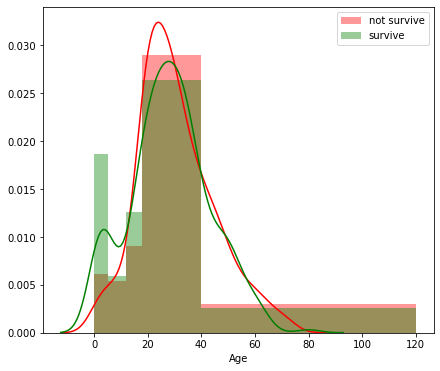

In [21]:
plt.figure(figsize=(7, 6))
sns.distplot(df.Age[df.Survived == 0], bins=[0, 5, 12, 18, 40, 120], color="r", label="not survive")
sns.distplot(df.Age[df.Survived == 1], bins=[0, 5, 12, 18, 40, 120], color="g", label="survive")
plt.legend();

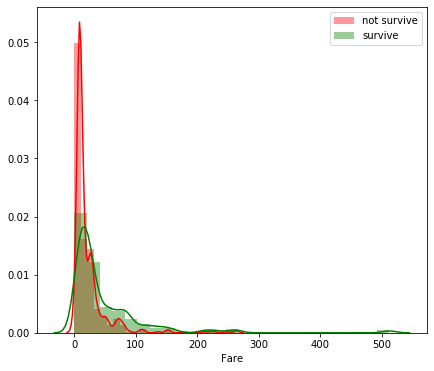

In [22]:
plt.figure(figsize=(7, 6))
sns.distplot(df.Fare[df.Survived == 0], bins=25, color="r", label="not survive")
sns.distplot(df.Fare[df.Survived == 1], bins=25, color="g", label="survive")
plt.legend();

### Kategorik vs Target

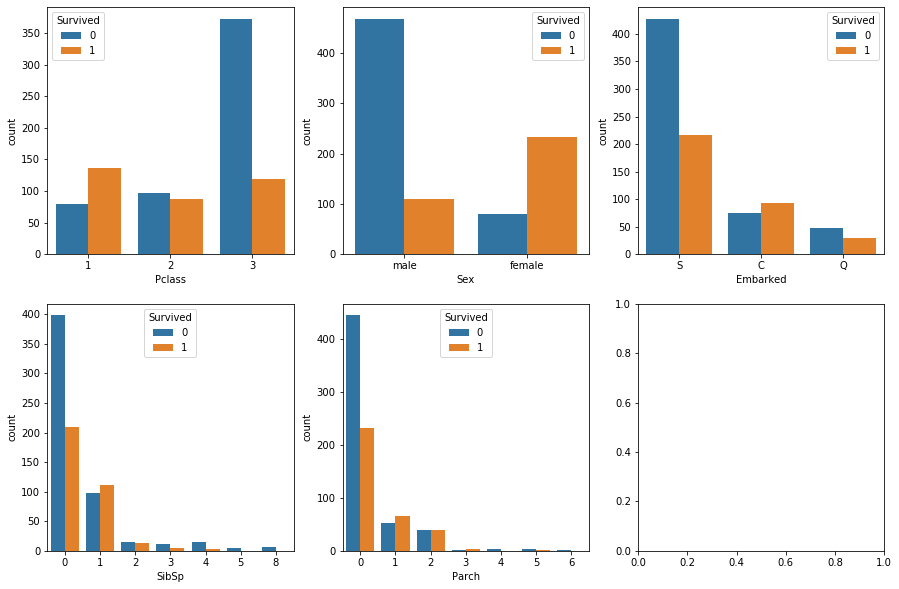

In [23]:
cat_var = ['Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch']

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for cat, a in zip(cat_var, ax.flatten()):
    sns.countplot(cat, data=df, hue="Survived", ax=a)

# Feature Engineering

### Adding feature -> isAlone

In [24]:
df["isAlone"] = (df.SibSp == 0) & (df.Parch == 0)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,isAlone
PassengerId,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,False
2,1,1,female,38.0,1,0,71.2833,C,False
3,1,3,female,26.0,0,0,7.9250,S,True
4,1,1,female,35.0,1,0,53.1000,S,False
5,0,3,male,35.0,0,0,8.0500,S,True


### binning

In [25]:
df.Age = pd.cut(df.Age, [0, 5, 12, 18, 40, 120], labels=["balita", "anak-anak", "remaja", "dewasa", "lansia"])
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,isAlone
PassengerId,,,,,,,,,
1,0,3,male,dewasa,1,0,7.2500,S,False
2,1,1,female,dewasa,1,0,71.2833,C,False
3,1,3,female,dewasa,0,0,7.9250,S,True
4,1,1,female,dewasa,1,0,53.1000,S,False
5,0,3,male,dewasa,0,0,8.0500,S,True


In [26]:
df.Fare = pd.cut(df.Fare, [0, 25, 100, 600], labels=["murah", "mahal", "eksekutif"])
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,isAlone
PassengerId,,,,,,,,,
1,0,3,male,dewasa,1,0,murah,S,False
2,1,1,female,dewasa,1,0,mahal,C,False
3,1,3,female,dewasa,0,0,murah,S,True
4,1,1,female,dewasa,1,0,mahal,S,False
5,0,3,male,dewasa,0,0,murah,S,True


# Dataset Splitting

In [28]:
X = df.drop(columns="Survived")
y = df.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 8), (179, 8), (712,), (179,))

# Preprocessor

In [29]:
from jcopml.pipeline import num_pipe, cat_pipe

In [30]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,isAlone
PassengerId,,,,,,,,
693,3,male,NaN,0,0,mahal,S,True
482,2,male,NaN,0,0,NaN,S,True
528,1,male,NaN,0,0,eksekutif,S,True
856,3,female,remaja,0,1,murah,S,False
802,2,female,dewasa,1,1,mahal,S,False


In [31]:
# numerical_pipeline = Pipeline([
#     ("imputer", SimpleImputer(strategy='median')),
#     ("scaler", StandardScaler())
# ])

# categorical_pipeline = Pipeline([
#     ("imputer", SimpleImputer(strategy='most_frequent')),
#     ("onehot", OneHotEncoder())
# ])

# Sama kayak diatas cuman diringkas
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling="minmax"), ["SibSp", "Parch"]),
    ('categoric', cat_pipe(encoder="onehot"), ["Pclass", "Sex", "Age", "Fare", "Embarked", "isAlone"]),
])

# Training

In [32]:
from jcopml.tuning import grid_search_params as gsp

In [41]:
parameter = {
    "algo__n_neighbors": np.arange(1, 51, 2),
    "algo__weights": ['uniform', 'distance'],
    "algo__p": [1, 2],
    "algo__algorithm": ["auto", "ball_tree"]
}
# gsp.knn_params

In [42]:
pipeline = Pipeline([
    ("prep", preprocessor),
    ("algo", KNeighborsClassifier())
])

model = GridSearchCV(pipeline, parameter, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.8s


{'algo__algorithm': 'auto', 'algo__n_neighbors': 25, 'algo__p': 2, 'algo__weights': 'distance'}
0.8792134831460674 0.8146237397912751 0.7988826815642458


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   10.7s finished


# Kadang, effort tidak sebanding dengan hasil

Oleh sebab itu, selalu mulai dengan model yang sederhana (yang effort nya sedikit). Lalu perlahan coba yang effortnya lebih berat.